In [1]:
# !pip install qiskit qiskit-optimization

> Define the ILP formulation of the BPP. You can use Docplex or similar frameworks to do it. 

Given $n$ items, each with an associated weight $w_i$, and bins with maximum weight (capacity) $C$. $x_{ij}$ represent decision variables that equals 1 if item $i$ is put into bin $j$, and $y_j$ = 1 if bin $j$ is used, bounded by the maximum number of bins $n$. The objective is to minimize the number of bins
$$
\quad \sum_{j=1}^{n} y_j
$$

subject to constraints that 
1. 1 item is assigned to 1 bin
$$
\quad \sum_{j=1}^{n} x_{ij} = 1, \quad \forall i = 1, \ldots, n
$$
2. total weight of items respect the bin capacity
$$
\quad \sum_{i=1}^{n} w_i x_{ij} \leq C, \quad \forall j = 1, \ldots, n
$$
3. if a bin is not used $y_j = 0$, no items should be assigned to it, so $x_{ij} = 0$ for all i. 
$$
\quad x_{ij} \leq y_j, \quad \forall i = 1, \ldots, n, \forall j = 1, \ldots, n
$$
We can also modify the right hand side of capacity constraint from C to $C y_j$, which could implies the last constraint, but it is separated to improve the performance of the model.


In [2]:
from docplex.mp.model import Model

def define_ilp(items_weight: list, bin_capacity: float, verbose = False) -> Model:
    """
    Define an integer linear programming model for the bin packing problem.

    Parameters
    ----------
    items_weight : list of float
        Weights of the items.
    bin_capacity : float
        naximum weight that a bin can hold.
    """
    N = len(items_weight)
    model = Model()
    x = {(i, j): model.binary_var() for i in range(N) for j in range(N)}
    y = [model.binary_var() for j in range(N)]
    model.minimize(model.sum(y[j] for j in range(N)))
    for i in range(N):
        model.add_constraint(model.sum(x[i, j] for j in range(N)) == 1)
    for j in range(N):
        model.add_constraint(model.sum(items_weight[i] * x[i, j] for i in range(N)) <= bin_capacity)
    for i in range(N):
        for j in range(N):
            model.add_constraint(x[i, j] <= y[j])
    if verbose:
        print(f"Number of variables: {model.number_of_variables} and constraints: {model.number_of_constraints}")
        print(f"Model objective: {model.get_objective_expr()}")
    return model


> Create a function to transform the ILP model into a QUBO 

The objective function is linear with the form $L x$ and quatradic with the form $x^T Q x$, where x is a vector of binary decision variables and Q is a square matrix of constants. As an alternative to ILP constraints, we introduce quadratic penalties into the objective function. 
1. In general, converting a equality constraint $a x = b$ to a penalty term $(a x - b)^2$ takes the form of
- constant $ C += b^2 $
- linear $ L[x_i] -= 2 coef[x_i] * b $
- quadratic $ Q[x_i, x_j] += coef[x_i] * coef[x_i] $

2. A inequality constraint can be converted to equality form by including slack variables in a binary expansion. The number of slack variables per equation is $log_2(b)$. The equation becomes $(a x + 2^l s_l = b)$, where $s$ is the slack variable with $2^l$ or $b - 2^l$ as the coefficient. The penalty term is then computed as above.

3. The constraint $x_i \leq x_j$ is special can be converted to $x_i - x_j x_i$.

The matrix L and Q is constructed as the first n rows (and columns) are the $x_{ij}$ variables, the next n are the $y_j$ variables, and the rest are the slack variables. The QUBO matrix is the sum of the penalties and objective function. 
For a small system with 2 items with weights 1 and 2 and 2 bins with capacity 3, assuming penalty factor is 1, 
1. the objective function is
$$
Q = x5 + x6
$$
2. Item Assignment Constraint:
rhs = 1, coefs = 1, an example of the penalty term is
$$
x1+x2 == 1
$$
$$
P_1 = (1 - x1 - x2)^2 = 1 - 2 x1 - 2 x2 + x1 x2 + x2 x1
$$

3. Bin Capacity Constraint:
number of slack variables = 2, rhs = 3, coefs = [1, 2, 1, 2], an example of the equality form is
$$
x1 + 2 x3 <= 3,
$$
$$
x1 + 2 x3 + s1 + 2 s2 = 3
$$

4. Bin Assignment Constraint:
$$
x1 <= x5, 
P_5 = x1 - x1 x5
$$

In [3]:
import numpy as np
import math
def constraint_to_penalty(num_total_variables, item_idx_list, penalty_factor, rhs, coeffs: np.ndarray):
    constant = penalty_factor * rhs ** 2
    linear = np.zeros(num_total_variables)
    quadratic = np.zeros((num_total_variables, num_total_variables))
    for item_idx in item_idx_list: # for each bin that item could be placed
        # linear term
        linear[item_idx] -= 2 * penalty_factor * rhs * coeffs[item_idx]
        # quadratic term
        for item_jdx in item_idx_list:
            quadratic[item_idx, item_jdx] += penalty_factor * coeffs[item_idx]* coeffs[item_jdx]
    return constant, linear, quadratic

def define_qubo(items_weight: list, bin_capacity: float, penalty_factor: float = 1.0, verbose = False) -> np.ndarray:
    """
    Define a QUBO model for the bin packing problem.

    Parameters
    ----------
    items_weight : list of float
        Weights of the items.
    bin_capacity : float
        Maximum weight that a bin can hold.
    penalty_factor : float
        Penalty factor for the constraints.
    """
    num_item = len(items_weight)
    item_variables = (0, num_item ** 2)
    bin_variables = (item_variables[1], item_variables[1] + num_item)
    num_slack_variables_per_eq = math.floor(np.log2(bin_capacity))
    last_slack_coeff = None
    if 2 **num_slack_variables_per_eq - 1 < bin_capacity:
        last_slack_coeff = bin_capacity + 1 - 2 ** (num_slack_variables_per_eq)
        num_slack_variables_per_eq += 1
    slack_variables = (bin_variables[1], bin_variables[1] + num_slack_variables_per_eq * num_item)
    num_total_variables = slack_variables[1]
    P2_coeffs = np.zeros(num_total_variables)
    for i in range(num_item):
        for j in range(num_item):
            P2_coeffs[i * num_item + j] = items_weight[i]
            
    for i in range(num_item):
        for l in range(num_slack_variables_per_eq):
            if last_slack_coeff is not None and l == num_slack_variables_per_eq - 1:
                P2_coeffs[slack_variables[0] + i * num_slack_variables_per_eq + l] = last_slack_coeff
            else:
                P2_coeffs[slack_variables[0] + i * num_slack_variables_per_eq + l] = 2 ** l
            
    constant = 0
    linear = np.zeros(num_total_variables)
    quadratic = np.zeros((num_total_variables, num_total_variables))
    # objective: 
    for i in range(bin_variables[0], bin_variables[1]):
        linear[i] = 1
    # constraints:
    # P_1 = (1 - x1 - x2 - ... - xN)^2 = 1 - 2 * (x1 + x2 + ... + xN) + (x1^2 + x2^2 + ... + xN^2)
    for i in range(0, num_item**2, num_item): # for constraints on each item
        item_idx_list = range(i, num_item + i)
        P1_coeffs = np.ones(num_total_variables)
        Pconstant, Plinear, Pquadratic = constraint_to_penalty(num_total_variables, item_idx_list, penalty_factor, 1, P1_coeffs)
        constant += Pconstant
        linear = np.add(linear, Plinear)
        quadratic = np.add(quadratic, Pquadratic)
    # P_2 = (x1 + x2 + ... + xN - y1)^2 = x1^2 + x2^2 + ... + xN^2 - 2 * (x1 * y1 + x2 * y2 + ... + xN * yN) + y1^2
    for b in range(0, num_item): # for each bin 
        item_idx_list = range(b, num_item**2, num_item) 
        slack_idx_list = range(slack_variables[0] + b * num_slack_variables_per_eq, slack_variables[0] + (b + 1) * num_slack_variables_per_eq)
        item_idx_list = list(item_idx_list) + list(slack_idx_list)
        Pconstant, Plinear, Pquadratic = constraint_to_penalty(num_total_variables, item_idx_list, penalty_factor, bin_capacity, P2_coeffs)
        constant += Pconstant
        linear = np.add(linear, Plinear)
        quadratic = np.add(quadratic, Pquadratic)
    # P_3 = x1 - x1x5 + x2 - x2x6 + ... 
    for b in range(0, num_item): # for each bin 
        bin_idx = bin_variables[0] + b
        for item_idx in range(b, num_item**2, num_item): # for each item that could be placed in the bin
            linear[item_idx] += penalty_factor
            # quadratic term
            quadratic[item_idx, bin_idx] -= penalty_factor
    # convert quadratic to upper triangular matrix by adding the lower triangular part
    quadratic += quadratic.T - np.diag(quadratic.diagonal())
    quadratic[np.tril_indices(num_total_variables, -1)] = 0
    if verbose:
        print(f"Total number of variables: {num_total_variables}, item idx {item_variables}, bin idx {bin_variables}, slack idx {slack_variables}")
        print(f"Offset: {constant}, num of linear terms: {np.count_nonzero(linear)}, num of quadratic terms: {np.count_nonzero(quadratic)}")
    return constant, linear, quadratic

> Test your function with specific instances (size small, medium, and big) 

In [4]:
import numpy as np
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

np.random.seed(42)

instances = {
    'small1': {
        'weights': [1, 2], 
        'bin_capacity': 3
    },
    'small2': {
        'weights': [2, 2], 
        'bin_capacity': 4
    },
    'medium': {
        'weights': [1, 2, 1, 2],
        'bin_capacity': 3 # cap the number of slack variables to 2
    },
    'large': {
        'weights': np.random.randint(1, 5, size=8),
        'bin_capacity': 7                     
    }
}
for instance in instances.keys():
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    constant, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'], penalty_factor=3.0, verbose=True)
    test_qp = from_docplex_mp(model)
    conv = QuadraticProgramToQubo(penalty=3.0)
    test_qubo = conv.convert(test_qp)
    test_constant = test_qubo.objective.constant
    test_linear = test_qubo.objective.linear.to_array() 
    test_quadratic = test_qubo.objective.quadratic.to_array()
    if np.isclose(constant, test_constant) and np.allclose(linear, test_linear) and np.allclose(quadratic, test_quadratic):
        print(f"{instance} instance: PASSED")
    else:
        print(f"{instance} instance: FAILED")
        print(f"constant error: {np.abs(constant - test_constant)}")
        print(f"linear error: {np.abs(linear - test_linear)}")
        print(f"quadratic error: {np.abs(quadratic - test_quadratic)}")

Total number of variables: 10, item idx (0, 4), bin idx (4, 6), slack idx (6, 10)
Offset: 60.0, num of linear terms: 10, num of quadratic terms: 26
small1 instance: PASSED
Total number of variables: 12, item idx (0, 4), bin idx (4, 6), slack idx (6, 12)
Offset: 102.0, num of linear terms: 12, num of quadratic terms: 36
small2 instance: PASSED
Total number of variables: 28, item idx (0, 16), bin idx (16, 20), slack idx (20, 28)
Offset: 120.0, num of linear terms: 28, num of quadratic terms: 124
medium instance: PASSED
Total number of variables: 96, item idx (0, 64), bin idx (64, 72), slack idx (72, 96)
Offset: 1200.0, num of linear terms: 96, num of quadratic terms: 816
large instance: PASSED


> Create a Brute Force solver for the QUBO problem and solve the specific instances. 

1. Generate all $2^n$ possible solutions; in practice, we can limit the search space by the constraints.
2. Evaluate the objective function for each combination
3. Track the best solution

For 4 items, total number of variables is 36, and the number of possible solutions is $2^{28} = 2.7 × 10^8$. For 8 items, total number of variables is 96, and the number of possible solutions is $2^{96} = 7.9 × 10^{28}$. The time complexity is $O(2^n)$, which is not feasible for large problems.

In [5]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

def qubo_brute_force(offset, linear, quadratic):
    from itertools import product
    num_vars = len(linear)
    min_energy = float('inf')
    min_state = None
    for state in product([0, 1], repeat=num_vars):
        energy = offset
        energy += np.dot(linear, state)
        energy += np.dot(state, np.dot(quadratic, state))
        if energy < min_energy:
            min_energy = energy
            min_state = state
    return min_state, min_energy
for instance in ['small1', 'small2']:
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    offset, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'])
    min_state, min_energy = qubo_brute_force(offset, linear, quadratic)
    print(f"{instance}: {min_state} with energy {min_energy}")
    
    # test with numpy minimum eigensolver
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    test_qp = from_docplex_mp(model)
    conv = QuadraticProgramToQubo(penalty=3.0)
    test_qubo = conv.convert(test_qp)
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(test_qubo)
    print(exact_result)

small1: (0, 1, 0, 1, 0, 1, 1, 1, 0, 0) with energy 1.0
fval=1.0, x0=0.0, x1=1.0, x2=0.0, x3=1.0, x4=0.0, x5=1.0, c2@int_slack@0=1.0, c2@int_slack@1=1.0, c3@int_slack@0=0.0, c3@int_slack@1=0.0, status=SUCCESS
small2: (0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0) with energy 1.0
fval=1.0, x0=0.0, x1=1.0, x2=0.0, x3=1.0, x4=0.0, x5=1.0, c2@int_slack@0=1.0, c2@int_slack@1=1.0, c2@int_slack@2=1.0, c3@int_slack@0=0.0, c3@int_slack@1=0.0, c3@int_slack@2=0.0, status=SUCCESS


> To solve the QUBO, use quantum annealing simulators. You can use the Dwave Ocean Framework.
1. convert the QUBO to a BinaryQuadraticModel in dimod
2. solve the BQM with the sampler

In [6]:
# !pip install dwave-ocean-sdk
# !dwave config create # config file created in github codespace

In [7]:
def list_to_dict(linear, quadratic):
    linear_dict = {i: linear[i] for i in range(len(linear))}
    quadratic_dict = {(i, j): quadratic[i, j] for i in range(len(quadratic)) for j in range(len(quadratic))}
    return linear_dict, quadratic_dict

In [8]:
from dwave.system import DWaveSampler, EmbeddingComposite
import dwave.inspector
import dimod

def quantum_annealing_qubo(offset, linear, quadratic):
    linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
    bqm = dimod.BinaryQuadraticModel(linear_dict, quadratic_dict, offset, vartype=dimod.BINARY)
    # Submit the QUBO to the quantum annealer
    sampler = EmbeddingComposite(DWaveSampler()) # generak
    sampleset = sampler.sample(bqm, num_reads = 100)
    best_solution = sampleset.first.sample
    best_energy = sampleset.first.energy
    return best_solution, best_energy

for instance in ['small1', 'small2']:
    offset, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'])
    best_solution, best_energy = quantum_annealing_qubo(offset, linear, quadratic)
    solution_list = [0] * (max(best_solution.keys()) + 1)
    for key, value in best_solution.items():
        solution_list[key] = int(value)
    print(f"best solution: {solution_list} with energy {best_energy}")

best solution: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0] with energy 1.0
best solution: [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1] with energy 1.0


> Use a Quantum Variational approach to solve the QUBO. 
- Cost function C 
    C is the value of the objective function for a given configuration and the minimum of C(θ) corresponds to the solution of the problem. In each run, C is the average energy among all samples or the average over a fixed percentage of the lowest sampled configurations, in the spirit of the conditional Value at risk (CVaR) method

- Ansatzes
The goal to design the ansatzes is to minimal number of entangling operations and quantum gates, not too many optimazation parameters, but also efficiently sample the Hilbert space. I will try the following ansatzes
    1. entanglement structure that mimics the item-bin relationship
    2. Linear entanglement: Every entangling layer is made up of two-qubit control Z gates between each qubit with its nearestneighbor qubit in a linear quantum processor topology
    $$ U(\theta) = \prod_{i=1}^{n} U_{i}(\theta) = \prod_{i=1}^{n} e^{-i \theta Z_{i} Z_{i+1}} $$

- Measure
- Build a function with input being the QUBO and Ansantz. Using a hybrid approach solved the QUBO. 


In [2]:
# !pip install pennylane --upgrade
# !pip install pylatexenc

  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=bfe0a73250ff46a52d2f08e0514f63c436d225a73ed5cd982e483b426d2c1787
  Stored in directory: /home/v-yingrchen/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
from collections import defaultdict

def list_to_dict(linear, quadratic):
    linear_dict = {i: linear[i] for i in range(len(linear))}
    quadratic_dict = defaultdict(int)
    for i in range(len(quadratic)):
        linear_dict[i] = linear_dict.get(i, 0) + quadratic[i, i]
        for j in range(i+1, len(quadratic)):
            quadratic_dict[(i, j)] = quadratic_dict.get((i, j), 0) + quadratic[i, j]
    return linear_dict, quadratic_dict

def bin_packing_cost(config, linear, quadratic, offset):
    """Compute the cost of a given configuration"""
    energy = offset
    for k, v in linear.items():
        energy += v * config[k]
    for k, v in quadratic.items():
        energy += v * config[k[0]] * config[k[1]]
    # Return the total energy of the Ising model
    return energy

# test with previous solution
offset, linear, quadratic = define_qubo(instances['small2']['weights'], instances['small2']['bin_capacity'])
linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
solution =  [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
# solution = [ 1 if x == 1 else -1 for x in solution]
bin_packing_cost(solution, linear_dict, quadratic_dict, offset)

In [ ]:
from scipy.optimize import minimize

def evaluate_samples(samples, linear, quadratic, offset = 0):
    """Evaluate the cost of a set of samples"""
    results = {}
    for sample in samples:
        result_str = "".join(str(i) for i in sample)
        results[result_str] = results.get(result_str, 0) + 1
    energies = {}
    total_energy = 0
    for sample, count in results.items():
        sample = [int(i) for i in list(sample)]
        energy = bin_packing_cost(sample, linear, quadratic, offset)
        energies[energy] = energies.get(energy, 0) + count
        total_energy += energy * count
    avg_energy = total_energy / len(samples)
    return results, energies, avg_energy

def qubo_objective(p, h, J, num_qubits, circuit, shots):
    """Objective function to minimize using the QAOA parameters"""
    
    def f(params):
        gammas = params[:p]
        betas = params[p:]
        samples = circuit(gammas, betas, p, h, J, num_qubits)
        _, _, avg_energy = evaluate_samples(samples, h, J)
        return avg_energy

    return f

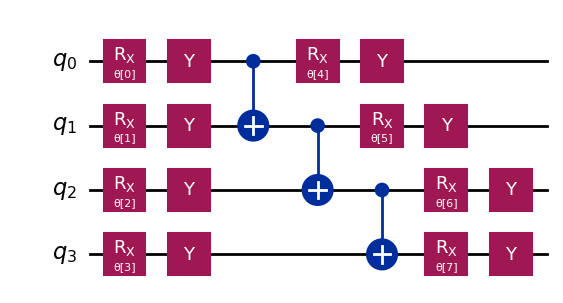

In [5]:
from qiskit.circuit.library import TwoLocal, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
TwoLocal_ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
TwoLocal_ansatz.decompose().draw("mpl")

from qiskit.circuit.library import EfficientSU2

EfficientSU2_ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
EfficientSU2_ansatz.decompose().draw("mpl")


In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
x0 = np.ones(8)
result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="BFGS")
result

> Use QAOA to solve the QUBO. 

Create from scratch a QAOA function. 
1. preparing qubits in an equal superposition over all possible states by applying a Hadamard gate to each qubit
2. in each run of circuit:
    1. in each layer (as p increases the approximation improves)
        1. apply the problem Hamiltonian to evolve the quantum state, making states with higher costs less favorable
        2. apply the mixer Hamiltonian to explore the solution space. The Pauli-X operator is applied to flip the qubits, helping the algorithm to explore different bitstrings (configurations).
    2. measure the quantum state to get a candidate solution
    3. parameters γ and β are optimized to minimize the cost function.

The cost Hamiltonian $H_c(Z) $ is obtained from the QUBO formulation
$$
H_c(\mathrm{z}) = \sum_{i, j > i}^{n} J_{ij} z_i z_j + \sum_{i=1}^n h_{i}z_i + O
$$
and translated into a parametric unitary gate given by
$$
U(H_c, \gamma_i)=e^{-i \gamma_i H_c},\tag{11} = e^{-i \gamma_i \left( \sum_{i<j}^{n-1} J_{ij}Z_iZ_j + \sum_{i}^{n-1} h_iZ_i\right)}
$$
where $\gamma_i$ is a parameter to be optimized. The term $e^{-i \gamma_i J_{ij}Z_iZ_j}$ is implemented by $RZZ(2 \gamma_i J_{ij})$, and $e^{-i \gamma_i h_iZ_i}$ is implemented by $RZ(2 \gamma_i h_i)$.
The mixer Hamiltonian $H_m(X)$ is a parametric unitary gate given by
$$
U(B, \beta_i)=e^{i \beta_i X},\tag{12}
$$
where $\beta_i$ is a parameter to be optimized. The term $e^{i \beta_i X}$ is implemented by $RX(2 \beta_i)$.

We repeat this sequence of gates p times. We also change the $x_i\in \{0, 1\}$ variables to spin variables $z_i\in \{-1, 1\}$ by the transformation $x_i = (1 - z_i)/2$.

In [61]:
import pennylane as qml

shots = 500  # Number of samples used
dev = qml.device("default.qubit", shots=shots)


@qml.qnode(dev)
def qaoa_circuit(gammas, betas, p, h, J, num_qubits):
    """The QAOA circuit to solve the bin packing problem
    Parameters:
    ----------
    gammas : list
        The list of angles for the cost Hamiltonian
    betas : list
        The list of angles for the mixer Hamiltonian
    h : dict
        The dictionary of the single-qubit terms in the cost Hamiltonian
    J : dict
        The dictionary of the two-qubit terms in the cost Hamiltonian
    num_qubits : int
        The number of qubits in the circuit
        
    Returns:
    -------
    samples : list
        The samples from the circuit
    """
    
    
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(h.values())))
    )  # Normalizing the Hamiltonian is a good idea
    
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    # repeat p layers the circuit
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qml.RZ(2 * gammas[layer] * v / wmax, wires=ki)
        for kij, vij in J.items():  # two-qubit terms
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)
    return qml.sample()

p = 10
betas = np.random.uniform(0, np.pi, p)
gammas = np.random.uniform(0, np.pi, p)
offset, linear, quadratic = define_qubo(instances['small1']['weights'], instances['small1']['bin_capacity'])
linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
n_qubits = len(linear)
first_samples = qaoa_circuit(gammas, betas, p, linear_dict, quadratic_dict, n_qubits)
first_results, first_energies, first_avg_energy = sort_samples(first_samples, linear_dict, quadratic_dict, offset)
print(first_avg_energy)


print(qml.draw(qaoa_circuit)(gammas, betas, p, linear_dict, quadratic_dict, n_qubits))

8.29
0: ──H──RZ(-3.36)─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●─╭●────────────╭●─╭●───────────╭●
1: ──H──RZ(-3.36)─╰X──RZ(1.35)─╰X─│────────────│──│────────────│──│─────────────│──│────────────│─
2: ──H──RZ(-5.38)─────────────────╰X──RZ(2.69)─╰X─│────────────│──│─────────────│──│────────────│─
3: ──H──RZ(-5.38)─────────────────────────────────╰X──RZ(0.00)─╰X─│─────────────│──│────────────│─
4: ──H──RZ(0.67)──────────────────────────────────────────────────╰X──RZ(-0.67)─╰X─│────────────│─
5: ──H──RZ(0.67)───────────────────────────────────────────────────────────────────╰X──RZ(0.00)─╰X
6: ──H──RZ(-3.36)─────────────────────────────────────────────────────────────────────────────────
7: ──H──RZ(-5.38)─────────────────────────────────────────────────────────────────────────────────
8: ──H──RZ(-3.36)─────────────────────────────────────────────────────────────────────────────────
9: ──H──RZ(-5.38)─────────────────────────────────────────────────────────────────────────────────

──╭●

uses the classical optimizer COBYLA to iteratively update gammas and betas, aiming to minimize a cost function that evaluates the QAOA circuit’s effectiveness in solving the bin-packing problem. 

In [62]:
from scipy.optimize import minimize

def qubo_objective(p, h, J, num_qubits):
    """Objective function to minimize using the QAOA parameters"""
    
    def f(params):
        gammas = params[:p]
        betas = params[p:]
        samples = qaoa_circuit(gammas, betas, p, h, J, num_qubits)
        _, _, avg_energy = sort_samples(samples, h, J)
        return avg_energy

    return f

p = 10
betas = np.random.uniform(0, np.pi, p)
gammas = np.random.uniform(0, np.pi, p)
params = np.concatenate([gammas, betas])
obj = qubo_objective(p, linear_dict, quadratic_dict, n_qubits)   
# Run classical optimization
opt_result = minimize(obj, params, method="COBYLA",  options = {'disp': True, 'maxiter': 1000})
opt_result


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -14.39
       x: [ 1.674e-03  1.345e+00 ...  2.268e-01  2.395e-01]
    nfev: 183
   maxcv: 0.0


   Normal return from subroutine COBYLA

   NFVALS =  183   F =-1.439000E+01    MAXCV = 0.000000E+00
   X = 1.673935E-03   1.344803E+00   2.873374E+00   1.849566E-01   9.972970E-01
       4.204947E+00   1.111708E-01   2.574342E+00   9.873508E-01   2.470392E-01
       2.038160E+00   1.627049E+00   1.930896E+00   2.778934E+00   1.434495E+00
       3.084650E+00   2.929839E+00   1.496128E+00   2.268370E-01   2.395164E-01


In [63]:
# Extract the optimized angles
opt_gammas = opt_result.x[:p]
opt_betas = opt_result.x[p:]

# Run QAOA circuit with optimized angles
final_samples = qaoa_circuit(opt_gammas, opt_betas, p, linear_dict, quadratic_dict, n_qubits)
final_results, final_energies, final_total_energy = sort_samples(final_samples, linear_dict, quadratic_dict, offset)
final_total_energy

5.938

/tmp/ipykernel_176591/2780043311.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


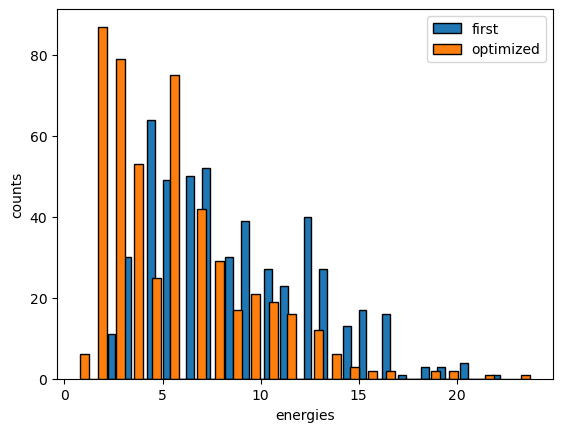

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(
    first_energies.keys(),
    weights=first_energies.values(),
    bins=50,
    edgecolor="black",
    label="first",
    align="right",
)
ax.hist(
    final_energies.keys(),
    weights=final_energies.values(),
    bins=50,
    edgecolor="black",
    label="optimized",
    align="left",
)
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("energies")
fig.show()
    

The optimized circuit gives more samples with low energy.

Compare and analyze the results. 

 time-to-solution (TTS). The TTS means a time
that is needed to a heuristic algorithm to find the solution
(ground state energy) with 99% success probability. It is
given by
TTS = taR99,

What is the difference between QAOA, Quantum Annealing, and Quantum Variational approaches with different Ansatz? 

The QUBO model has emerged as an underpinning of the quantum computing area known as quantum annealing and Fujitsu's digital annealing, and has become a subject of study in neuromorphic computing.

QVE variational optimization of a quantum circuit to minimize the expectation value of a given Hamiltonian. The optimization is performed iteratively, with the quantum circuit parameters updated at each step until the most optimal solution is determined. 

QAOA, on the other hand, is a quantum algorithm that prepares a quantum state that is a superposition of all possible solutions to the problem. The algorithm applies a sequence of unitary operations to the initial state, with the number of operations and their parameters being determined by the problem the QAOA algorithm has been designed to solve.

VQE is better suited for problems that require a high degree of precision, while QAOA is better suited for problems with a large array of initial possibilities. VQE is known to be more efficient than QAOA for problems with a lower variety of initial solutions, as it can converge to the optimal solution faster. However, for problems with a higher variety of initial solutions, VQE may become computationally expensive due to the exponential growth of the required resources. QAOA, on the other hand, is designed to handle problems with a large search space efficiently.

How do the results compare with the brute force approach? 

All tasks were grouped by fuel elements quantity for
demonstrating results (see Fig. 1). We note that the DWave annealer shows good result in problem solving in
the small-size cases (2 possible canisters and 2 elements),
while optimal solution was not found for 6 and more elements problem. The standard deviation of TTS is significantly increase with elements quantity for all methods.
This is caused by an exponential growth of the space of
possible solutions, leading to a decrease in the probability
of finding the optimal solution. As a result, the annealing
process often terminates at a suboptimal point instead
of the ground state. This is especially true for complex
problems that require a large number of variables to be
taken into consideration.


## References
1. Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models https://arxiv.org/pdf/1811.11538
2. A Quantum Approximate Optimization Algorithm https://arxiv.org/pdf/1411.4028
3. Variational quantum algorithms https://arxiv.org/pdf/2012.09265
4. https://arxiv.org/pdf/2103.14479
4. Quantum and quantum-inspired optimization for solving the minimum bin packing problem https://arxiv.org/pdf/2301.11265

Tutorials:
1. qiskit optimization Converters for Quadratic Programs https://github.com/qiskit-community/qiskit-optimization/blob/807d48167caf11cd93bec85f26b34614fb7868da/docs/tutorials/02_converters_for_quadratic_programs.ipynb#L16
2. Dwave Solving Problems with Quantum Samplers https://docs.dwavesys.com/docs/latest/c_gs_3.html
2. Pennylane Quadratic Unconstrained Binary Optimization (QUBO) https://pennylane.ai/qml/demos/tutorial_QUBO/
3. Ansatze and Variational Forms https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms
3. Comparing VQE and QAOA: Two Quantum Algorithms for Optimization Problems https://www.quantumgrad.com/article/700
4. https://openqaoa.entropicalabs.com/what-is-the-qaoa/